In [58]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [3]:
from zipfile import ZipFile
data_path = 'Flickr8k/archive (13).zip'
with ZipFile(data_path, 'r') as zip:
    zip.extractall()
    print('The data set has been extracted.')
image_path= os.path.join('Images')
data = pd.read_csv("captions.txt")
data.head()

The data set has been extracted.


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


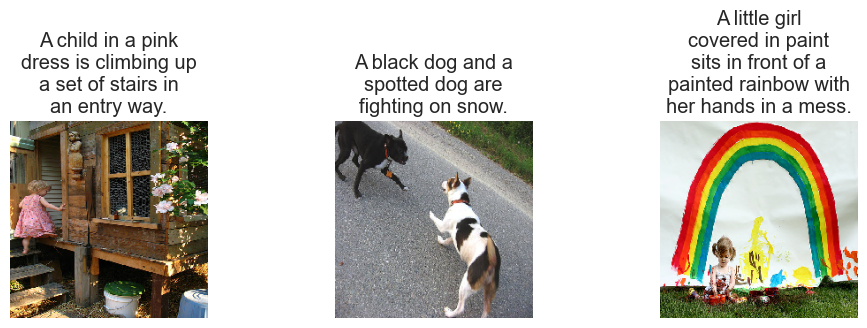

In [5]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from textwrap import wrap

# Function to read and preprocess images
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    return img

# Function to display images with captions
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(len(temp_df)):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image_path = os.path.join('Images', temp_df.image[i])
        if os.path.exists(image_path):
            image = readImage(image_path)
            plt.imshow(image)
            plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        else:
            print(f"File not found: {image_path}")
            plt.text(0.5, 0.5, 'File not found', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.axis("off")

# Example DataFrame (ensure that temp_df is populated with correct image IDs and captions)
import pandas as pd
temp_df = pd.DataFrame({
    'image': ['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg'],
    'caption': ['A child in a pink dress is climbing up a set of stairs in an entry way.',
                'A black dog and a spotted dog are fighting on snow.',
                'A little girl covered in paint sits in front of a painted rainbow with her hands in a mess.']
})

# Display images
display_images(temp_df)

In [7]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [9]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
print(captions[:10])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri-colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [13]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [23:15<00:00,  5.80it/s]


In [15]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [17]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [35]:
# from tensorflow.keras.utils import plot_model
# plot_model(caption_model)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [19]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 1920)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │         491,776 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 34)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 256)            │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 34, 256)           │       2,172,160 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 35, 256)           │               0 │ reshape[0][0],             │
│                               │                           │                 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 256)               │         525,312 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dropout[0][0], dense[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          32,896 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 8485)              │       1,094,565 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [23]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,monitor="val_loss",mode="min",save_best_only = True,verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

In [25]:
history = caption_model.fit(train_generator,epochs=50,validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 5.6960
Epoch 1: val_loss improved from inf to 4.29412, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 272s 502ms/step - loss: 5.6948 - val_loss: 4.2941 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 4.3377
Epoch 2: val_loss improved from 4.29412 to 3.96786, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 266s 494ms/step - loss: 4.3375 - val_loss: 3.9679 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - loss: 4.0252
Epoch 3: val_loss improved from 3.96786 to 3.82410, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 254s 473ms/step - loss: 4.0252 - val_loss: 3.8241 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - loss: 3.8388
Epoch 4: val_loss improved from 3.82410 to 3.73322, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 254s 472ms/step - loss: 3.8387 - val_loss: 3.7332 - learning_rate: 0.0010
Epoch 5/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 3.7178
Epoch 5: val_loss improved from 3.73322 to 3.68124, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 264s 491ms/step - loss: 3.7178 - val_loss: 3.6812 - learning_rate: 0.0010
Epoch 6/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - loss: 3.6006
Epoch 6: val_loss improved from 3.68124 to 3.63860, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 254s 474ms/step - loss: 3.6006 - val_loss: 3.6386 - learning_rate: 0.0010
Epoch 7/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - loss: 3.5172
Epoch 7: val_loss improved from 3.63860 to 3.62328, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 254s 472ms/step - loss: 3.5172 - val_loss: 3.6233 - learning_rate: 0.0010
Epoch 8/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 3.4564
Epoch 8: val_loss did not improve from 3.62328
537/537 ━━━━━━━━━━━━━━━━━━━━ 257s 479ms/step - loss: 3.4564 - val_loss: 3.6328 - learning_rate: 0.0010
Epoch 9/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - loss: 3.4012
Epoch 9: val_loss improved from 3.62328 to 3.62190, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 266s 496ms/step - loss: 3.4012 - val_loss: 3.6219 - learning_rate: 0.0010
Epoch 10/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 3.3353
Epoch 10: val_loss improved from 3.62190 to 3.61402, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 257s 479ms/step - loss: 3.3353 - val_loss: 3.6140 - learning_rate: 0.0010
Epoch 11/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - loss: 3.2827
Epoch 11: val_loss did not improve from 3.61402
537/537 ━━━━━━━━━━━━━━━━━━━━ 254s 474ms/step - loss: 3.2827 - val_loss: 3.6350 - learning_rate: 0.0010
Epoch 12/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 3.2483
Epoch 12: val_loss did not improve from 3.61402
537/537 ━━━━━━━━━━━━━━━━━━━━ 261s 486ms/step - loss: 3.2483 - val_loss: 3.6388 - learning_rate: 0.0010
Epoch 13/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 3.1950
Epoch 13: val_loss did not improve from 3.61402

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
537/537 ━━━━━━━━━━━━━━━━━━━━ 263s 491ms/step - loss: 3.1951 - val_loss: 3.6722 - learning_rate: 0.0010
Epoch 14/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 3.1312
Epoch 14: val_loss did not improve from 3.61402
537/537 ━━━━━━━━━━━━━━━━━━━━ 257s 478

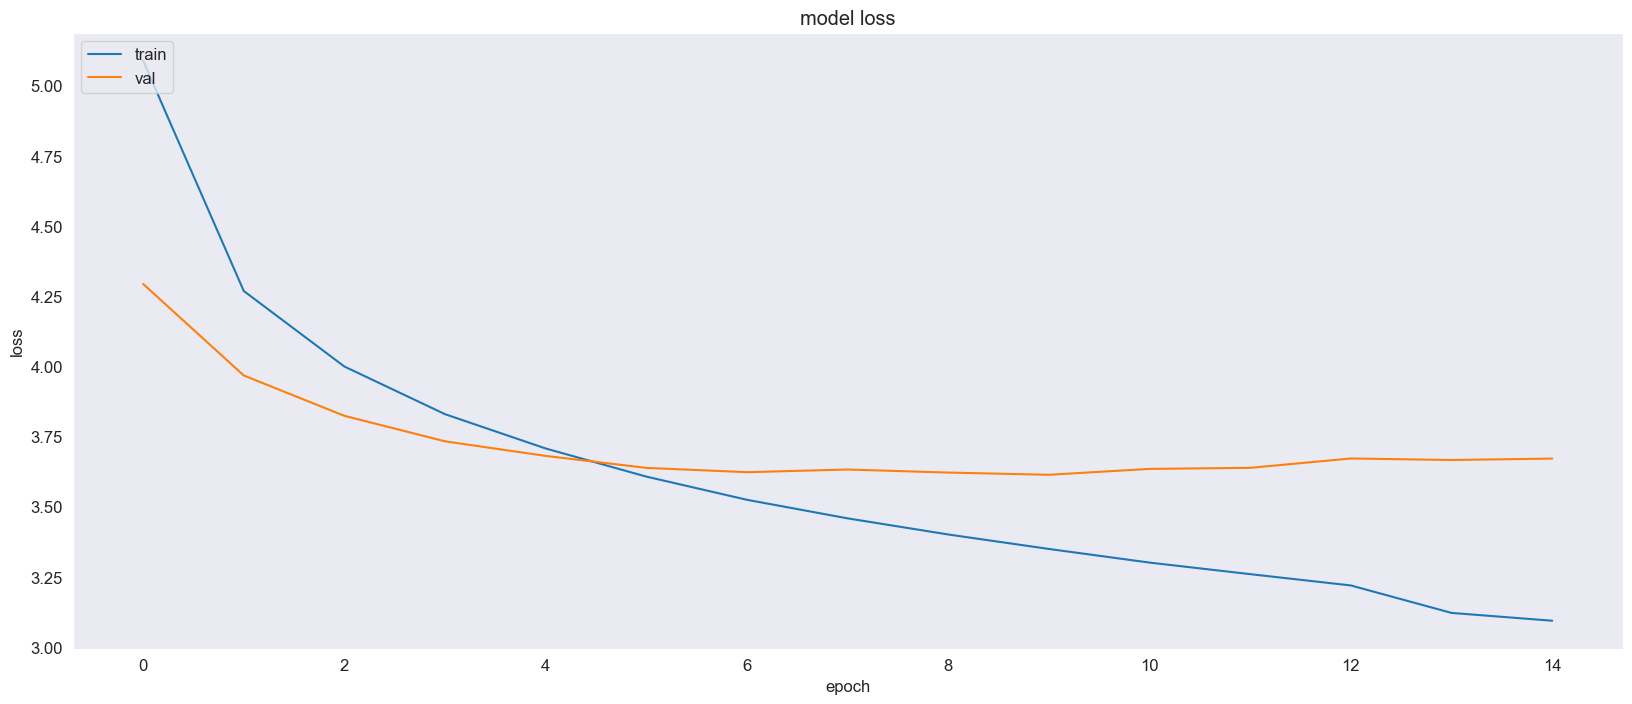

In [27]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [31]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text+= " " + word
        if word == 'endseq':
            break
    return in_text

In [33]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [60]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption
    print("Generated Caption:", caption)

Generated Caption: startseq man is jumping over the water endseq
Generated Caption: startseq black dog is playing with the camera endseq
Generated Caption: startseq two children are standing on the street endseq
Generated Caption: startseq black dog is running through the snow endseq
Generated Caption: startseq man in red jacket is skiing down snowy hill endseq
Generated Caption: startseq man in blue shirt is standing on the beach endseq
Generated Caption: startseq boy in blue shirt is playing in pool endseq
Generated Caption: startseq boy is sitting on the ground endseq
Generated Caption: startseq boy in blue shirt is jumping over the air endseq
Generated Caption: startseq two people are standing on the street endseq
Generated Caption: startseq the boy is sitting on the floor endseq
Generated Caption: startseq two children are playing in the grass endseq
Generated Caption: startseq man in blue shirt is standing on the street endseq
Generated Caption: startseq man in blue shirt is jump

In [64]:
brimg = 'OIP.jpeg'
imgman = image.load_img(brimg, target_size=(224, 224))
man = image.img_to_array(imgman)
man = np.expand_dims(man, axis=0)
man /= 255.0

image_feature = fe.predict(man, verbose=0)
features['man.jpeg'] = image_feature
caption = predict_caption(caption_model, 'man.jpeg', tokenizer, max_length, features)
print("Generated Caption:", caption)


Generated Caption: startseq two people are sitting on the sidewalk endseq
